In [1]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.0


In [2]:
data_news_headlines = pd.read_json("./data/x1.json")

# Adjust news headline data
data_news_headlines = data_news_headlines.drop(columns='article_link', axis=1)
data_news_headlines = data_news_headlines.rename(columns ={'headline':'text', 'is_sarcastic':'label'})
data_news_headlines = data_news_headlines.reindex(columns=['text','label'])
data_news_headlines.head()

,text,label
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [3]:
data_tweets = pd.read_csv("./data/dataset_csv.csv")

# Adjust tweets data
data_tweets = data_tweets.rename(columns={'tweets':'text'})
data_tweets.head()

,text,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [4]:
data_sitcoms = pd.read_csv("./data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [5]:
data_reddit = pd.read_csv("./data/train-balanced-sarcasm.csv")

# Adjust reddit data
data_reddit = data_reddit.drop(columns=['author','subreddit','score','ups','downs','date','created_utc','parent_comment'], axis=1)
data_reddit = data_reddit.rename(columns={'comment':'text'})
data_reddit = data_reddit.reindex(columns=['text','label'])

data_reddit.head()

,text,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme isn't funny none of the ""new york ni...",0
4,I could use one of those tools.,0


In [6]:
# Combine all 4 datasets
data = pd.concat([data_news_headlines,data_tweets,data_sitcoms,data_reddit], ignore_index=True)

# Shuffle the rows
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,text,label
0,"A new sniper, exactly what we need",1.0
1,Amen to that...,1.0
2,like you need to put more than one hive in one...,1.0
3,This was posted 3 days ago.. You could have at...,0.0
4,Did you inhaled it?,0.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042641 entries, 0 to 1042640
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   text    1042588 non-null  object 
 1   label   1042641 non-null  float64
dtypes: float64(1), object(1)
memory usage: 15.9+ MB


In [8]:
##create arrays to store the headlines and labels
text = list(data['text'])
labels = list(data['label'])
#text_dataset = tf.data.Dataset.from_tensor_slices(text)

In [9]:
##define the parameters for tokenizing and padding
vocab_size = 10000
embedding_dim = 32
max_length = 120
padding_type = 'post'
trunc_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [10]:
##create the text vectorization layer and create the vocab
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, standardize='lower_and_strip_punctuation', split='whitespace', output_mode='int', output_sequence_length=max_length)

vectorize_layer.adapt(text)

In [11]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 120)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 320,817
Trainable params: 320,817
Non-trai

In [12]:
##training set from 0 to training size
training_sentences = text[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = text[training_size:]
testing_labels = labels[training_size:]

In [13]:
num_epochs = 30
history = model.fit(
    training_sentences, 
    training_labels, 
    epochs=num_epochs, 
    validation_data=(testing_sentences, testing_labels)
    )

Epoch 1/30
625/625 [==============================] - 309s 494ms/step - loss: 0.6918 - accuracy: 0.5250 - val_loss: 0.6876 - val_accuracy: 0.5702
Epoch 2/30
625/625 [==============================] - 284s 455ms/step - loss: 0.6625 - accuracy: 0.6086 - val_loss: 0.6412 - val_accuracy: 0.6427
Epoch 3/30
625/625 [==============================] - 289s 463ms/step - loss: 0.6005 - accuracy: 0.6802 - val_loss: 0.6345 - val_accuracy: 0.6440
Epoch 4/30
625/625 [==============================] - 281s 451ms/step - loss: 0.5606 - accuracy: 0.7095 - val_loss: 0.6213 - val_accuracy: 0.6589
Epoch 5/30
625/625 [==============================] - 280s 449ms/step - loss: 0.5328 - accuracy: 0.7307 - val_loss: 0.6552 - val_accuracy: 0.6467
Epoch 6/30
625/625 [==============================] - 287s 460ms/step - loss: 0.5076 - accuracy: 0.7505 - val_loss: 0.6656 - val_accuracy: 0.6483
Epoch 7/30
625/625 [==============================] - 288s 461ms/step - loss: 0.4895 - accuracy: 0.7584 - val_loss: 0.6663 -

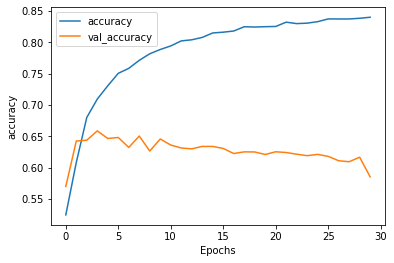

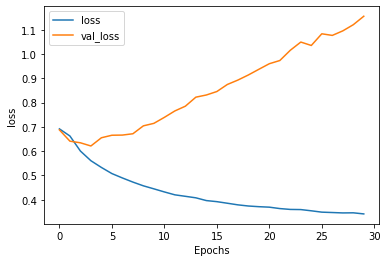

In [14]:
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [15]:
sentences = ["Now we know why some animals eat their own children.", "game of thrones season finale showing this sunday night","Please, keep talking. I always yawn when I am interested."]
print(model.predict(sentences))

1/1 [==============================] - 0s 119ms/step
[[0.9419514 ]
 [0.00359233]
 [0.02821289]]


In [16]:
model.save('./model')

INFO:tensorflow:Assets written to: ./model\assets
